# Chapter 3: Classification

### MNIST
MNIST Dataset: 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau.

In [1]:
# Fetch MNIST dataset:
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata('MNIST original', transpose_data=True, data_home='files')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([0., 0., 0., ..., 9., 9., 9.])}

In [2]:
X, y = mnist["data"], mnist["target"]
X.shape, y.shape

((70000, 784), (70000,))

5.0

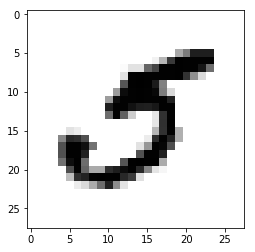

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation='nearest')
y[36000]

In [4]:
# Create Train and test sets
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [5]:
# Shuffle the datasets
import numpy as np

shuffle_ix = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_ix], y_train[shuffle_ix]

### Training a Binary Classifier

In [6]:
# Binary classifier: 5-detector
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [7]:
# Create SGD Classifier (Stochastic Gradient Descent) and train it on the whole dataset
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [8]:
sgd_clf.predict([some_digit])

array([ True])

### Performance Measures

In [9]:
# Measuring Accuracy using Cross-Validation
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_ix, test_ix in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_ix]
    y_train_folds = (y_train_5[train_ix])
    X_test_fold = X_train[test_ix]
    y_test_fold = (y_train_5[test_ix])
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9695
0.96645
0.96475


In [10]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9695 , 0.96645, 0.96475])

In [11]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [12]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91   , 0.9125 , 0.90645])

### Confusion Matrix
A much better way to evaluate the performance of a classifier is to look at the confusion matrix.

In [13]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [14]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53868,   711],
       [ 1275,  4146]])

[[true negatives (53954), false positives (625)], 53954 were correctly classified as non-5s, 625 were wrongly classifed as 5s.

[false negatives (1695), true positives (3726)]] 1695 were wrongly classified as non-5s, 3726 were correctly classified as 5s.

In [15]:
confusion_matrix(y_train_5, y_train_5)

array([[54579,     0],
       [    0,  5421]])

### Precision and Recall
Precision = TP / (TP + FP)

Recall (Sensitivity or true positive rate (TPR)): this is the ratio of positive instances that are correctly detected by the classifier

recall = TP / (TP + FN)

In [16]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred), recall_score(y_train_5, y_train_pred)

(0.8536133415688697, 0.7648035417819591)

When it claims an image represents a 5, it is correct only 85% of the time.
Moreover, it only detects 68% of the 5s.

In [17]:
# F1 score: combine the precision and recall (the harmonic mean of precision and recall)
# F1 = TP / (TP + ((FN + FP)/2))
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.8067717454757736

### Precision/Recall Tradeoff

In [18]:
# Return a score for each instance, and then make predictions based on those scores using any threshold
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([162521.764152])

In [19]:
# The SGDClassifier using a threshold equal to 0
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [20]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [21]:
# Get scores of all instances in the training set using the cross_val_predict()
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
y_scores

array([-355879.07470786, -293703.19323581, -268077.2945995 , ...,
       -525993.32917801, -789924.99052956, -277428.70945355])

In [22]:
# Compute precision and recall for all possible threshold using the precision_recall_curve
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

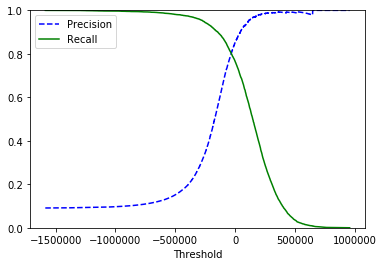

In [23]:
# Plot precision and recall as functions of the threshold value
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [24]:
# Aim for 90% precision. plot above estimates the threshold to be about 90,000
y_train_pred_90 = (y_scores > 90000)
precision_score(y_train_5, y_train_pred_90), recall_score(y_train_5, y_train_pred_90)

(0.9344721366563987, 0.6155690831949825)

### The ROC Curve
The receiver operating characteristic curve is another common tool used with binary classifiers.
The ROC curve plots the true positive rate (another name for recall) against the false positive rate.
The TNR is also called specificity. Hence the ROC curve plots sensitivity (recall) versus 1 - specificity.

In [25]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

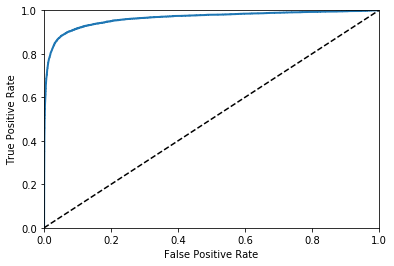

In [26]:
# Plot the FPR against the TPR
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()

In [27]:
# Measure the ROC AUC (Receiver operating characteristic area under curve)
# A perfect classifier will have a ROC AUC equal to 1, 
# whereas a purely random classifier will have a ROC AUC equal to 0.5
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9637954537071796

In [28]:
# Train RandomForestClassifier and compare its ROC curve and ROC AUC score to the SGDClassifier.
from sklearn.ensemble import RandomForestClassifier

forest_clf  = RandomForestClassifier(random_state =42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

# score = proba of  positive class
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

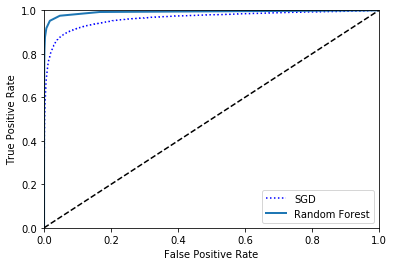

In [29]:
# Plot ROC curve
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="bottom right")
plt.show()

In [30]:
roc_auc_score(y_train_5, y_scores_forest)

0.9921735866869719

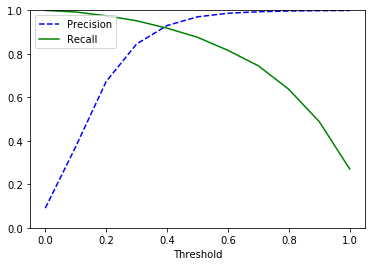

In [31]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores_forest)

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [32]:
# Precision and recall score of Random Forest Classifier
y_train_pred_forest = (y_scores_forest > 0.4)
precision_score(y_train_5, y_train_pred_forest) , recall_score(y_train_5, y_train_pred_forest)

(0.9701858280579947, 0.8764065670540491)

### Multiclass Classification

In [33]:
# Scikit-learn detects when you try to use a binary classification algorithm for a multiclass classification task,
# and it automatically runs OvA (one-versus-all)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5.])

In [34]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-368260.59872593, -507796.8737911 , -203589.1622199 ,
        -179748.64677084, -445014.70030635,  162521.764152  ,
        -669232.88530035, -234088.87941796, -684509.21035549,
        -671033.16320475]])

In [35]:
np.argmax(some_digit_scores)

5

In [36]:
sgd_clf.classes_

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [37]:
sgd_clf.classes_[5]

5.0

In [38]:
# Force scikitlearn to use OvO (OneVsOneClassifier) or OvA (OneVsRestClassifier)
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5.])

In [39]:
len(ovo_clf.estimators_)

45

In [40]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5.])

In [41]:
# Scikit-Learn did not have to run OvA or OvO because Random Forest classifiers 
# can directly classify instances into multiple classes. You can call predict_proba() to get the list of
# probabilites that the classifier assigned to each instance for each class:
forest_clf.predict_proba([some_digit])

array([[0.1, 0. , 0. , 0.1, 0. , 0.8, 0. , 0. , 0. , 0. ]])

In [42]:
# Use cross-validation: evaluate the SGDClassifier's accuracy using the cross_val_score
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.8684763 , 0.86529326, 0.87478122])

In [43]:
# Scale the inputs for improvement
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.91371726, 0.91139557, 0.9073361 ])

### Error Analysis

In [44]:
# Confusion Matrix
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5719,    2,   27,    9,   10,   53,   46,   11,   40,    6],
       [   1, 6477,   45,   25,    6,   46,    9,   12,  111,   10],
       [  55,   35, 5347,   95,   82,   22,   95,   56,  153,   18],
       [  45,   38,  141, 5325,    1,  248,   38,   55,  145,   95],
       [  20,   26,   42,   11, 5373,   10,   53,   28,   79,  200],
       [  63,   42,   36,  173,   71, 4634,  113,   29,  174,   86],
       [  27,   22,   42,    2,   41,   86, 5650,    4,   44,    0],
       [  23,   19,   80,   27,   54,   11,    6, 5792,   18,  235],
       [  51,  143,   71,  151,   14,  155,   60,   24, 5050,  132],
       [  41,   33,   28,   84,  177,   36,    2,  192,   74, 5282]])

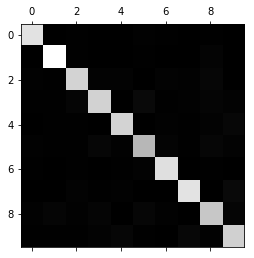

In [45]:
# Use matshow()
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [46]:
# Divide each value in the confusion matrix by the number of images in the corresponding class,
# so you can compare error rates instead of absolute number of errors
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

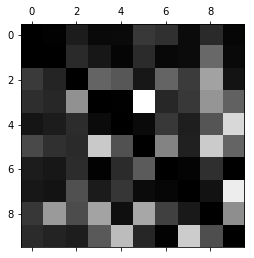

In [47]:
# Fill the diagonal with zeros to keep only the errors and plot
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Looking at this plot, it seems that your efforts should be spent on improving classification on 8s and 9s, as well as fixing the specific 3/5 confusion.  For example, you could try to gather more training data for these digits.  Or you could engineer new features that would help the classifier -- for example, writing an algorithm to count the number of closed loops (e.g., 8 has 2, 6 has 1, 5 has none).  Or you could preprocess the images (e.g., using SciKit-Image, Pillow, or OpenCV) to make some patterns stand out more, such as closed loops.

In [48]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

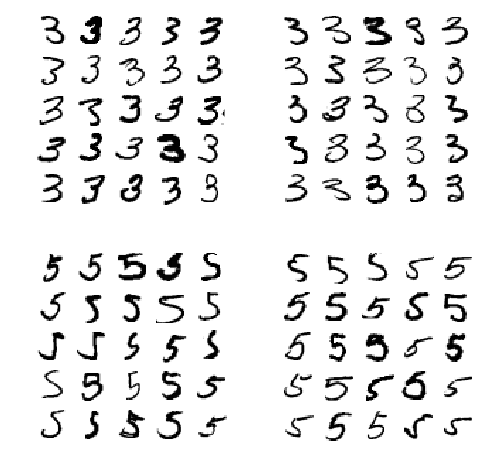

In [49]:
# plot examples of 3s and 5s
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

The reason is that we used a simple SGDClassifier, which is a linear model. All it does is assign a weight per class to each pixel, and when it sees a new image it just sums up the weighted pixel intensities to get a score for each class. So since 3s and 5s differ only by a few pixels, this model will easily confuse them. One way to reduce the 3/5 confusion would be to preprocess the images to ensure that they are well centered and not too rotated.

### Multilabel Classification

In [50]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [51]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [52]:
# some_digit = 5; >7:False, odd:True
knn_clf.predict([some_digit])

array([[False,  True]])

In [53]:
# Compute the average F1 score across all labels
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
f1_score(y_train, y_train_knn_pred, average="macro")

0.9678473868632915

### Multioutput Classification

In [54]:
noise_train = np.random.randint(0, 100, (len(X_train), 784))
noise_test = np.random.randint(0, 100, (len(X_test), 784))
X_train_mod = X_train + noise_train
X_test_mod = X_test + noise_test
y_train_mod = X_train
y_test_mod = X_test

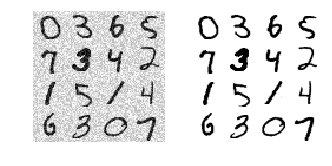

In [55]:
# peek at an images
plt.figure(figsize=(8,8))
plt.subplot(231); plot_digits(X_train_mod[:16], images_per_row=4)
plt.subplot(232); plot_digits(y_train_mod[:16], images_per_row=4)

In [56]:
# Train the classifer and make it clean the images
knn_clf.fit(X_train_mod, y_train_mod)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

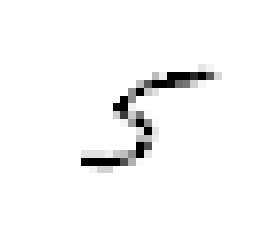

In [57]:
clean_digit = knn_clf.predict([X_test_mod[6000]])
plot_digits(clean_digit, images_per_row=1)